In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape, mapping
import json
import geemap,ee
import folium
ee.Authenticate()
ee.Initialize()

In [2]:
#se carga el primer iceberg a estudiar
iceberg1 = pd.read_csv('0003_06_01__05_12.csv', sep="&")

In [3]:
iceberg1.head()

,fecha,similaridad,area,centroide,poligono,source,covers
0,2020-06-01,0.932003,1.037304e+08,"[-105.86525521394687, -74.4844911612252]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,2020-06-06,0.908518,1.049709e+08,"[-105.91986792088849, -74.44201168227734]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,2020-06-11,0.898057,1.001686e+08,"[-106.17683309386798, -74.34499706400955]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,2020-06-16,0.936059,9.871248e+07,"[-106.06671230478825, -74.39021769184886]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,2020-06-16,0.936059,9.871248e+07,"[-106.06671230478825, -74.39021769184886]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [4]:
#se preprocesan los datos para dejarlos aptos para el estudio

iceberg1.drop_duplicates(inplace=True)
iceberg1.reset_index(drop=True, inplace=True)
iceberg1['centroide'] = iceberg1['centroide'].apply(lambda x: x.strip('][').split(', '))
iceberg1['centroide'] =  iceberg1['centroide'].apply(lambda x: list((float(x[0]), float(x[1]))))
iceberg1['fecha'] = pd.to_datetime(iceberg1['fecha'])
iceberg1['lon'] = iceberg1['centroide'].apply(lambda x: x[0])
iceberg1['lat'] = iceberg1['centroide'].apply(lambda x: x[1])
iceberg1 = gpd.GeoDataFrame(
    iceberg1, geometry=gpd.points_from_xy(iceberg1['lon'], iceberg1['lat']), crs="EPSG:4326"
)

La siguiente funcion ayuda a transformar el ee.FeatureCollection de la columna poligono que esta en formato str.

In [5]:
import re

def trans(contenido_celda):
    # Eliminar caracteres no válidos antes y después del JSON
    contenido_celda = contenido_celda.strip()

    match = re.search(r'(\{.*\})', contenido_celda, re.DOTALL)
    # Intentar cargar el JSON
    if match:
        json_str = match.group(1)
        
        # Intentar cargar el JSON
        try:
            json_dict  = json.loads(json_str)

            features = json_dict['functionInvocationValue']['arguments']['features']['arrayValue']['values']

            # Convertir cada característica a un objeto ee.Feature
            ee_features = []
            for feature in features:
                geom = feature['functionInvocationValue']['arguments']['geometry']['functionInvocationValue']['arguments']['coordinates']['constantValue']
                if isinstance(geom[0][0], list):
                    ee_geom = ee.Geometry.Polygon(geom)
                else:
                    ee_geom = ee.Geometry.MultiLineString(geom)
                ee_feature = ee.Feature(ee_geom)
                ee_features.append(ee_feature)
            
            # Crear la FeatureCollection
            fc = ee.FeatureCollection(ee_features)
            return fc
        except json.JSONDecodeError as e:
            print("Error al decodificar JSON:", e)
    else:
        print("No se encontró un JSON válido en la cadena.")

La siguiente celda crea el archivo "iceberg_movimiento.html" el cual muestra el mapa con las ubicaciones historicas del iceberg durente 1 año. Asi dando una idea de el area de trabajo y patrones del iceberg.

In [7]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate("2021-06-01", "2021-06-02")\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean()

Map = geemap.Map(center=[iceberg1['lat'].iloc[0], iceberg1['lon'].iloc[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style1 = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style1 = {'color': 'blue', 'pointSize': 5}
polygon_style2 = {'color': 'blue', 'fillColor': 'blue', 'fillOpacity': 0.5}
point_style2 = {'color': 'black', 'pointSize': 5}

#la variable j se asegura de mostrar un iceberg cada 5 iteraciones asi no se
#laggea tanto el mapa
j=0
for i, row in iceberg1.iterrows():
    if i == j + 5:
        variable = trans(row.poligono)
        Map.addLayer(variable, polygon_style1, f'ice{i}')
        j = i
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style1, f'centro-ice{i}')


Map.addLayerControl()
Map.save("iceberg_movimiento.html")

## Estudio de corrientes
Ahora se hara uso de 2 datasets de corrientes marinas en la Antartida de la organizacion National Snow and Ice Data Center. Cada dataset contiene datos de las corrientes de cada dia del 2020 y 2021 respectivamente.

In [8]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import geemap

In [9]:
from shapely.geometry import Point
import pyproj

ds1 = xr.open_dataset('icemotion_daily_sh_25km_20200101_20201231_v4.1.nc')
ds2 = xr.open_dataset('icemotion_daily_sh_25km_20210101_20211231_v4.1.nc')

Las siguientes 2 funciones generan por completo un geodataframe de las corrientes marinas, el cual es filtrado por la zona de estudio (esta zona se definira para cada iceberg manualmente).

In [10]:
#crear geodataframe desde archivos .nc
def gdf_corrientes(ds, time):
    # time es el dia del a;o
    u = ds['u'].isel(time=time).values
    v = ds['v'].isel(time=time).values
    x = ds['x'].values
    y = ds['y'].values

    # Crear un transformador de coordenadas usando EPSG:3409
    proj_from = pyproj.Proj("epsg:3409")  # EASE-Grid South
    proj_to = pyproj.Proj(proj="latlong", datum="WGS84")

    # Usar pyproj.Transformer para transformar las coordenadas
    transformer = pyproj.Transformer.from_proj(proj_from, proj_to, always_xy=True)

    # Crear listas para las geometrías y componentes de velocidad
    geometries = []
    us = []
    vs = []

    # Iterar sobre las dimensiones y convertir las coordenadas
    for i in range(len(y)):
        for j in range(len(x)):
            lon, lat = transformer.transform(x[j], y[i])
            if not np.isnan(u[i, j]) and not np.isnan(v[i, j]):
                point = Point(lat, lon)
                geometries.append(point)
                us.append(u[i, j])
                vs.append(v[i, j])

    # Crear un GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': geometries, 'u': us, 'v': vs}, crs='EPSG:3409')
    return gdf

In [14]:
#filtrar por zona de estudio
def filtrar_gdf(gdf, min_lat, max_lat, min_lon, max_lon):

    filtered_gdf = gdf[(gdf.geometry.x >= min_lat) & (gdf.geometry.x <= max_lat) &
                    (gdf.geometry.y >= min_lon) & (gdf.geometry.y <= max_lon)]
    return filtered_gdf

El siguiente codigo generara mapas con las corrientes de cada dia que se tenga un iceberg detectado y se creara un gif para poder visualizar el movimiento.

In [11]:
import os
import imageio
import geemap.foliumap as geemap
import folium

In [16]:
#Esta funcion crea un mapa con las corrientes y la ubicacion del iceberg
def create_map(centro, zoom,  lat1, lon1, filtered_gdf, filename):
    m = geemap.Map(location=centro, zoom_start=zoom)

    # marcador para el iceberg 
    folium.Marker(
        location=[lat1, lon1],
        popup=f'x{lat1}'
    ).add_to(m)


    # este loop instancia las flechas que representan las corrientes
    for _, row in filtered_gdf.iterrows():
        folium.Marker(
            location=[row.geometry.x, row.geometry.y],
            icon=folium.DivIcon(html=f"""<div style="transform: rotate({np.arctan2(row['v'], row['u'])}rad);">
                                        <svg width="10" height="10">
                                        <line x1="0" y1="5" x2="10" y2="5" style="stroke:blue;stroke-width:2;" />
                                        <line x1="7" y1="2" x2="10" y2="5" style="stroke:blue;stroke-width:2;" />
                                        <line x1="7" y1="8" x2="10" y2="5" style="stroke:blue;stroke-width:2;" />
                                        </svg>
                                        </div>""")

        ).add_to(m)

    # Guardar el mapa en un archivo HTML temporal
    m.save(filename)

In [12]:
#esta funcion devuelve el dia del año en 1 numero de 0 a 365 
#para filtrar en el dataset de corrientes
def get_time(row, year):
    fecha1 = row['fecha']
    fecha2 = dt.datetime.strptime(f'{year}-01-01', '%Y-%m-%d')
    tiempo = (fecha1 - fecha2).days
    return tiempo

Para poder crear el gif se necesitaran las paginas html de cada mapa y eventualmente se obtendran todas las imagenes png de cada html. Para no llenar el repositorio, solo se subiran los gifs finales, igualmente si se corre el codigo se crearan todos los html y png.

In [17]:
#esta sera la area de estudio que se definio manualmente en google earth engine
min_lat, max_lat = -75.28135004454685, -71.94540023979573
min_lon, max_lon = -114.50716047524229, -100.40071516274229


image_filenames = []
html_filenames = []
year = '2020'
ds = ds1
for i, row in iceberg1.iterrows():
    html_file = f'map_{i}.html'
    image_file = f'map_{i}.png'

    #verificar si se paso de año para evitar errores de index
    if row['fecha'].year == 2021:
        year = '2021'
        ds = ds2

    #se obtiene el dataset filtrado de las corrientes
    time = get_time(row, year)
    gdf = gdf_corrientes(ds, time)
    filtered_gdf = filtrar_gdf(gdf, min_lat, max_lat, min_lon, max_lon)

    centro = [-73.73582154069716,-107.4563592346886] #este es el centro del area de estudio que tambien se definio desde google earth engine
    #se crea el mapa
    create_map(centro, 6, row['lat'], row['lon'],
            filtered_gdf, html_file)

    #se guarda el html
    os.system(f"wkhtmltoimage {html_file} {image_file}")
    image_filenames.append(image_file)
    html_filenames.append(html_file)

In [18]:
#se usara selenium para poder acceder a los html y obtener una imagen del mapa

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time

options = Options()
options.add_argument('--disable-gpu')

# Inicializar el controlador de Chrome
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# Lista de archivos HTML
html_files = ["map1.html", "map2.html", "map3.html"]
image_files = []
current_directory = os.getcwd()

for i, html_file in enumerate(html_filenames):
    full_path = os.path.join(current_directory, html_file)
    driver.get(full_path)
    time.sleep(1)  # Esperar a que el mapa se cargue completamente
    image_file = f"map_{i}.png"
    driver.save_screenshot(image_file)
    image_files.append(image_file)

driver.quit()

In [19]:
from PIL import Image

durations = [1000] * len(image_files)  # 1 segundo para cada imagen en el gif
images = [Image.open(image_file) for image_file in image_files]

#se crea el gif y se guarda
images[0].save(
    'map_animation.gif',
    save_all=True,
    append_images=images[1:],
    duration=durations,
    loop=0
)

#### El gif y el estudio de las corrientes se puede hacer para cualquier iceberg que se haya trackeado. Ahora se mostrara otro iceberg que logramos trackear por unos meses para tener otra referencia.

In [20]:
iceberg21 = pd.read_csv('0005_06_01__08_06.csv',sep="&")
iceberg22 = pd.read_csv('0005_08_06__08_24.csv',sep="&")

In [21]:
iceberg2 = pd.concat([iceberg21, iceberg22]).reset_index(drop=True)

In [22]:
iceberg2.drop_duplicates(inplace=True)
iceberg2.reset_index(drop=True, inplace=True)
iceberg2['centroide'] = iceberg2['centroide'].apply(lambda x: x.strip('][').split(', '))
iceberg2['centroide'] =  iceberg2['centroide'].apply(lambda x: list((float(x[0]), float(x[1]))))
iceberg2['fecha'] = pd.to_datetime(iceberg2['fecha'])
iceberg2['lon'] = iceberg2['centroide'].apply(lambda x: x[0])
iceberg2['lat'] = iceberg2['centroide'].apply(lambda x: x[1])
iceberg2 = gpd.GeoDataFrame(
    iceberg2, geometry=gpd.points_from_xy(iceberg2['lon'], iceberg2['lat']), crs="EPSG:4326"
)

El proceso a seguir sera exactamente el mismo solo que variando el area de estudio.

In [23]:
#area de estudio definida a mano
min_lat, max_lat = -76.9307256698451, -72.58105508154013
min_lon, max_lon = -174.6786824414576, -150.1571980664576

image_filenames = []
html_filenames = []
year = '2020'
ds = ds1
for i, row in iceberg2.iterrows():
    html_file = f'map2_{i}.html'
    image_file = f'map2_{i}.png'

    if row['fecha'].year == 2021:
        year = '2021'
        ds = ds2

    time = get_time(row, year)
    gdf = gdf_corrientes(ds, time)
    filtered_gdf = filtrar_gdf(gdf, min_lat, max_lat, min_lon, max_lon)
    centro = [-74.93676335468494, -162.9013386914576] #centro del area de estudio definida a mano
    create_map(centro, 5, row['lat'], row['lon'],
            filtered_gdf, html_file)


    os.system(f"wkhtmltoimage {html_file} {image_file}")
    image_filenames.append(image_file)
    html_filenames.append(html_file)

In [24]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time

options = Options()
options.add_argument('--disable-gpu')

# Inicializar el controlador de Chrome
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)

# Lista de archivos HTML
image_files = []
current_directory = os.getcwd()

for i, html_file in enumerate(html_filenames):
    full_path = os.path.join(current_directory, html_file)
    driver.get(full_path)
    time.sleep(2)  # Esperar a que el mapa se cargue completamente
    image_file = f"map2_{i}.png"
    driver.save_screenshot(image_file)
    image_files.append(image_file)

In [25]:
durations = [1000] * len(image_files)  
images = [Image.open(image_file) for image_file in image_files]

#se guarda el gif
images[0].save(
    'map_animation2.gif',
    save_all=True,
    append_images=images[1:],
    duration=durations,
    loop=0
)

### Estudio de las distancias y velocidad

In [37]:
import math

#Esta funcion calcula la distancia en metros para cualquier set de 2 coordenadas
def distancia(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Radio de la Tierra en metros
    R = 6371000
    
    # Diferencias de coordenadas
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Fórmula de Haversine
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distancia
    distancia = R * c
    
    return round(distancia, 2)

#Esta funcion calculara la velocidad promedio de un rango de dias entre 2 fechas
def velocidad(coor1, coor2, fecha1, fecha2):
    tiempo = (fecha1 - fecha2).days
    if tiempo == 0:
        return 1
    lat1, lon1 = coor1
    lat2, lon2 = coor2
    dist = distancia(lat1, lon1, lat2, lon2)
    velocidad = np.abs(dist / tiempo)
    return velocidad

In [40]:
#esta funcion creara 3 graficos para poder analizar el movimiento de un iceberg estudiado
def graficos_movimiento(iceberg):
    distancias = [0]  # La primera distancia es 0 porque no hay punto previo
    vel = [0]  # La primera velocidad es 0 porque no hay punto previo
    for i in range(1, len(iceberg)):
        lat1, lon1 = iceberg.loc[i-1, 'centroide']
        fecha1 = iceberg.loc[i-1, 'fecha']
        lat2, lon2 = iceberg.loc[i, 'centroide']
        fecha2 = iceberg.loc[i, 'fecha']
        dist = distancia(lat1, lon1, lat2, lon2)
        distancias.append(dist)
        vel.append(velocidad((lat1, lon1), (lat2, lon2), fecha1, fecha2))

    f"Mean: {np.mean(vel)}, Var: {np.var(vel)}"
    fig, axs = plt.subplots(3, 1, figsize=(11, 16))  # Tres filas, una columna

    # Gráfico de Líneas para Distancia y Velocidad
    axs[0].plot(iceberg['fecha'], distancias, color='red', label='Distancia (m)')
    axs[0].set_xlabel('Fecha')
    axs[0].set_ylabel('Distancia (m)')
    axs[0].legend(loc='upper left')
    ax2 = axs[0].twinx()
    ax2.plot(iceberg['fecha'], vel, color='blue', label='Velocidad (m/día)')
    ax2.set_ylabel('Velocidad (m/día)')
    ax2.legend(loc='upper right')
    axs[0].set_title('Distancia y Velocidad del Iceberg por Fecha')
    axs[0].grid(True)

    # Histograma para la Distancia y Velocidad
    axs[1].hist(distancias, bins=20, color='red', alpha=0.7, label='Distancia')
    axs[1].hist(vel, bins=20, color='blue', alpha=0.5, label='Velocidad')
    axs[1].set_title('Histogramas de Distancia y Velocidad')
    axs[1].set_xlabel('Distancia (m) / Velocidad (m/día)')
    axs[1].set_ylabel('Frecuencia')
    axs[1].legend()  # Mostrar leyenda
    axs[1].grid(True)

    # Box Plot para Distancia y Velocidad
    axs[2].boxplot([distancias, vel], notch=True, patch_artist=True, 
                labels=['Distancia (m)', 'Velocidad (m/día)'])
    axs[2].set_title('Box Plot de Distancia y Velocidad del Iceberg')
    axs[2].grid(True)

    # Ajuste de espaciado
    plt.tight_layout()
    plt.show()

#### Graficos para el primer iceberg

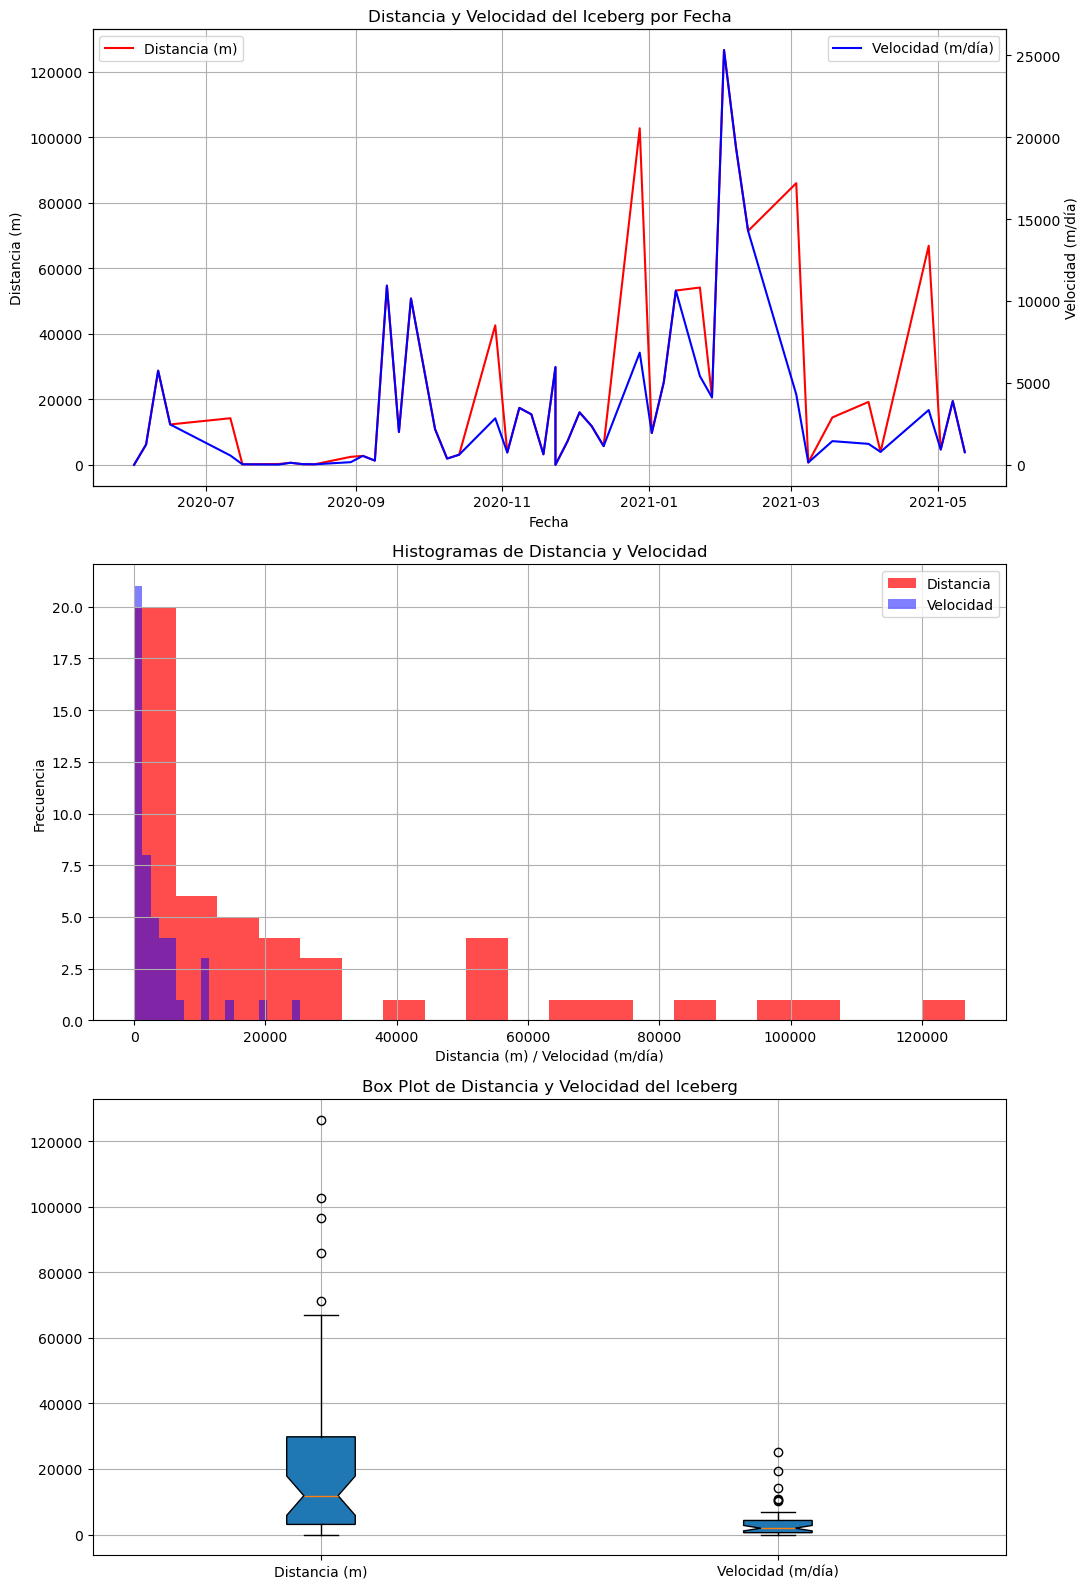

In [41]:
graficos_movimiento(iceberg1)

#### Graficos para el segundo iceberg

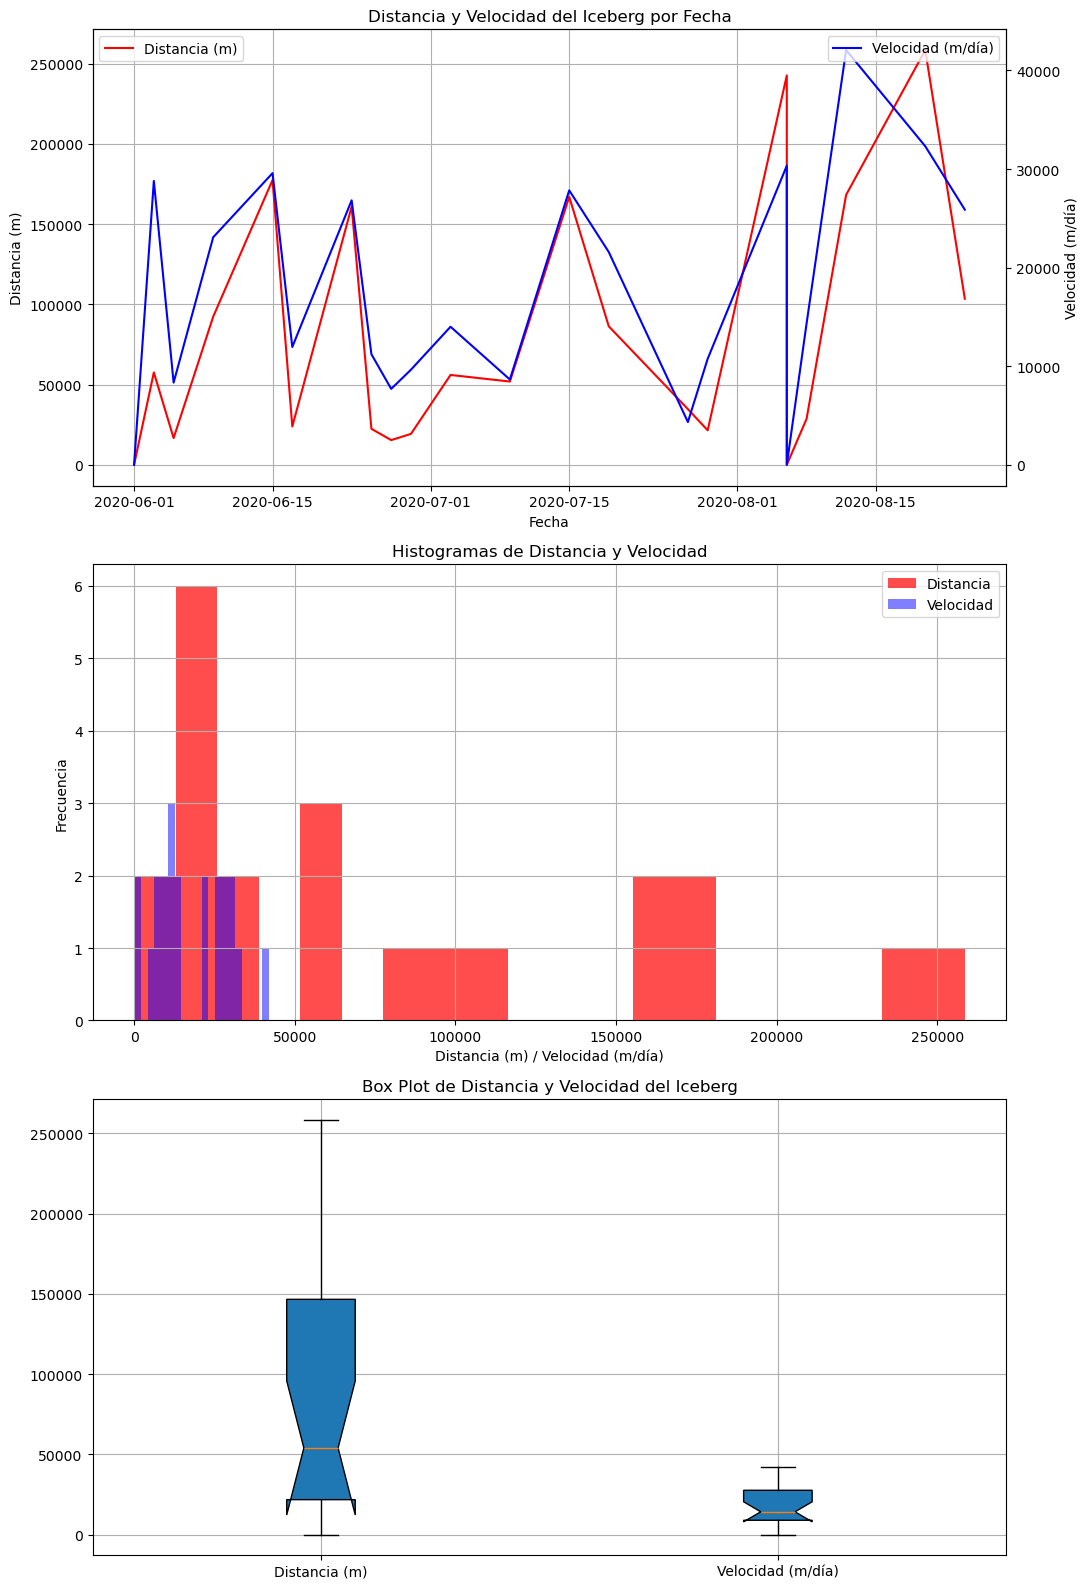

In [42]:
graficos_movimiento(iceberg2)